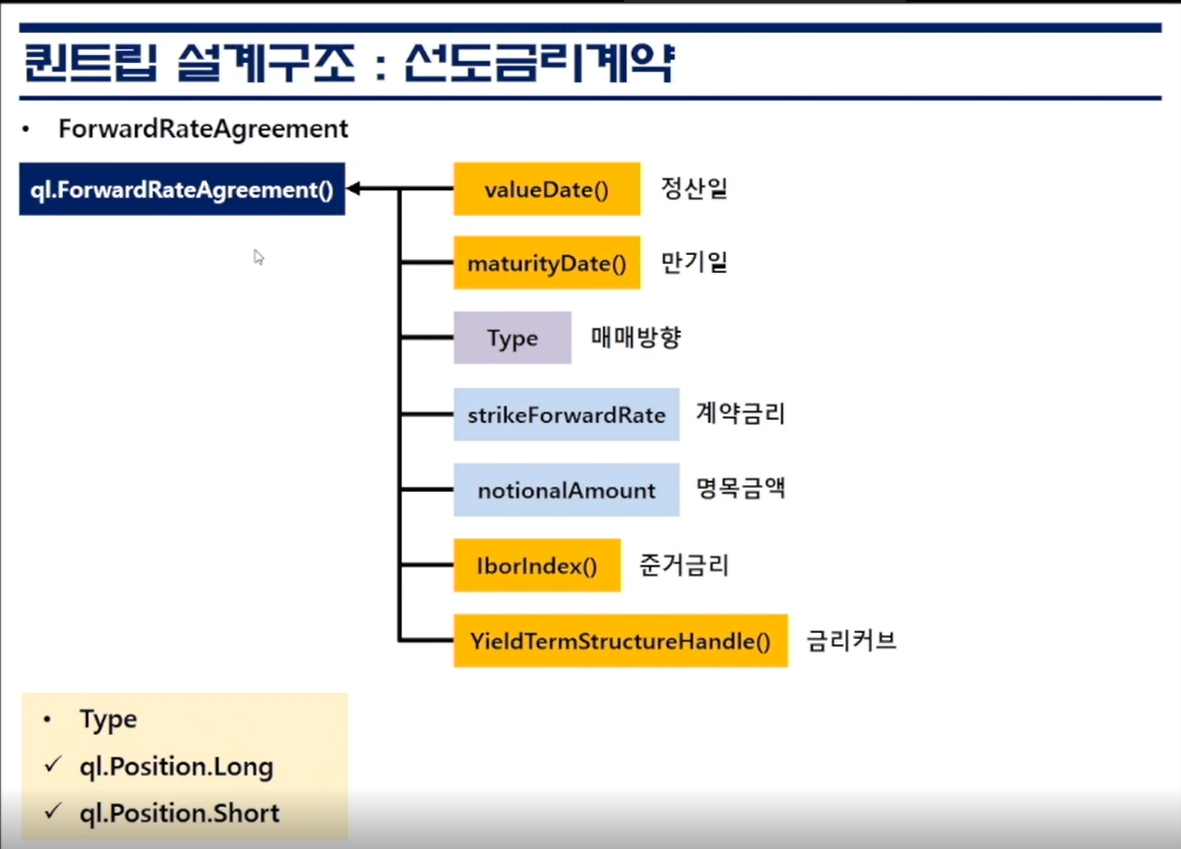

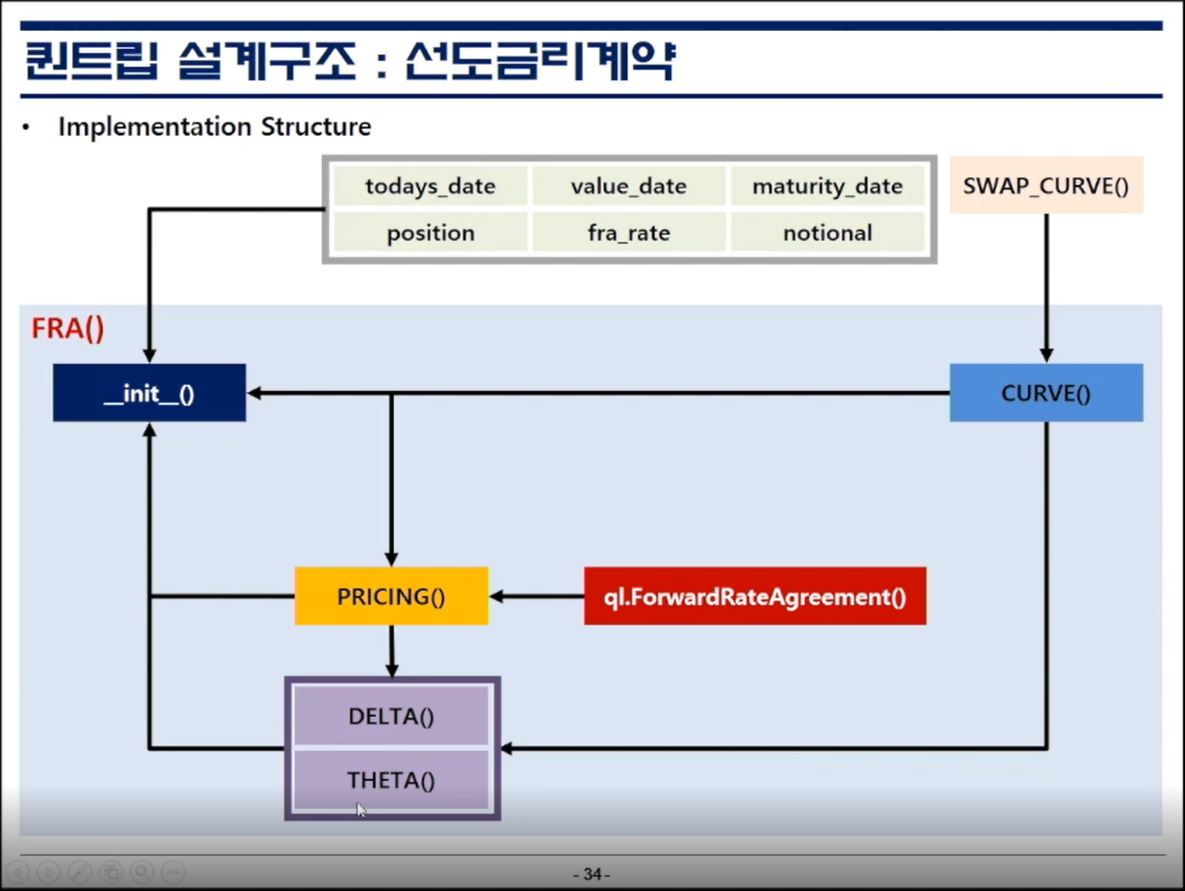

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import datetime
import QuantLib as ql

%load_ext autoreload
%autoreload 2
from SWAP_CURVE_hb import GET_QUOTE, SWAP_CURVE

class FRA():
    def __init__(self, todays_date, value_date, maturity_date, position, fra_rate, notional):
        self.date = todays_date
        self.curve = self.CURVE(self.date)
        
        self.value_date = ql.Date(value_date.day, value_date.month, value_date.year)
        self.maturity_date = ql.Date(maturity_date.day, maturity_date.month,maturity_date.year)
        
        if position == 'Long':
            self.position = ql.Position.Long
        elif position == 'Short':
            self.position = ql.Position.Short
            
        self.fra_rate = fra_rate
        self.notional = notional
        
        #pricing 결과
        #이론가가 들어감
        self.npv = self.PRICING(self.curve)
        self.delta = self.DELTA()
        self.theta = self.THETA()
        
    def CURVE(self, date):
        return SWAP_CURVE(date, GET_QUOTE(date))
    
    def PRICING(self, curve):
        curve_handle = ql.YieldTermStructureHandle(curve)
        # 이 시장금리를 토대로 usd 3개월 리보금리를 쓰겠다
        usd_3m_libor = ql.USDLibor(ql.Period(3, ql.Months), curve_handle)
        
        #FRA pricing
        fra = ql.ForwardRateAgreement(self.value_date,
                                     self.maturity_date,
                                     self.position,
                                     self.fra_rate,
                                     self.notional,
                                     usd_3m_libor,
                                     curve_handle)
        npv = fra.NPV()
        return npv
    
    def DELTA(self):
        curve_handle = ql.YieldTermStructureHandle(self.curve)
        
        # 1bp
        basis_point = 0.0001
        
        # FRA Price when 1bp up
        # 1bp 만큼 움직였을 때의 새로운 커브
        up_curve = ql.ZeroSpreadedTermStructure(curve_handle, ql.QuoteHandle(ql.SimpleQuote(basis_point)))
        up_fra = self.PRICING(up_curve)
        
        # 1bp down
        down_curve = ql.ZeroSpreadedTermStructure(curve_handle, ql.QuoteHandle(ql.SimpleQuote(-basis_point)))
        down_fra = self.PRICING(down_curve)
        
        # delta
        delta = (up_fra - down_fra) / 2
        return delta
    
    def THETA(self):
        price_t0 = self.PRICING(self.CURVE(self.date))
        price_t1 = self.PRICING(self.CURVE(self.date + datetime.timedelta(days=1)))
        theta = price_t1 - price_t0
        return theta
    
if __name__ == '__main__':
    todays_date = datetime.date(2020,10,7)
    effective_date = datetime.date(2020,10,17)
    maturity_date = datetime.date(2020,12,15)
    position = "Long"
    fra_rate = 0.0022
    notional = 10000000
    
    fra = FRA(todays_date,
             effective_date,
             maturity_date,
              position,
              fra_rate,
              notional)
    
    print(f"price = {round(fra.npv, 4)}")
    print(f"delta = {round(fra.delta, 4)}")
    print(f"theta = {round(fra.theta, 4)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
price = 87.545
delta = 163.9108
theta = 0.0467
